Este notebook é baseado no ```./noiseExperimentsAnalysis.ipynb```, porém seu foco está apenas nos experimentos de transferência com dados de origem ruidosos considerando o domínio NELL Sports. Em nossos últimos experimentos, notamos que o NELL Sports é sensível ao ruído adicionado ao domínio de origem e aos hiperparâmetros de nosso método. Porém, nossa metodologia parece apresentar uma falha, pois cada iteração da validação cruzada realiza apenas uma divisão aleatória entre domínios de origem e de destino e gera apenas um ruído. Sendo assim, os resultados podem estar dependentes da divisão e do ruído gerado. Para reduzir esse problema, rodamos novos experimentos com diferentes `randomSeed` a fim gerar novas divisões e ruídos a cada iteração. Isso aumenta significativamente a quantidade de experimentos a serem realizados e esse é o motivo pelo qual focamos inicialmente apenas no NELL Sports. Se for necessário, realizaremos as mesmas análises para os outros experimentos. Para não alterar o que já tá funcionando no notebook ```./noiseExperimentsAnalysis.ipynb```, realizamos essas análises preliminares neste novo notebook.

In [1]:
import sys
sys.path.append("..")

import re
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm
from glob import glob
from matplotlib import pyplot as plt
from utils.utils import getHashFromDict, readContentFromFile
from concurrent.futures import ProcessPoolExecutor
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

In [2]:
EXPERIMENTS_BASE_PATH = "./experiments/noisyTransferLearning-onlyNELLSports-beta-0.5/noisyTransferLearning"

In [3]:
def calculateUtility(experimentId, targetUtilityAlphaList):
    foldPredictionPathList = glob(f"{EXPERIMENTS_BASE_PATH}-*/{experimentId}/**/aucTemp.txt", recursive = True)
    utilities = []
    for predictionPath in foldPredictionPathList:
        fold = re.findall(r".*(fold[0-9]+).*", predictionPath)[0]
        foldUtilities = []
        for targetUtilityAlpha in targetUtilityAlphaList:
            oneMinusTargetUtilityAlpha = 1 - targetUtilityAlpha
            foldPredictions = readContentFromFile(predictionPath).strip()
            foldPredictions = pd.DataFrame([
                [float(value) for value in instance.split(" ")] for instance in foldPredictions.split("\n")
            ], columns = ["prob", "label"])
            foldPredictions["label"] = foldPredictions.label.astype(int)
            foldPredictions["pmf"] = foldPredictions.apply(lambda row: row.prob if row.label == 1 else (1-row.prob), axis = 1)
            foldPredictions["alphaFairness"] = foldPredictions.pmf.apply(lambda z: np.log(z) if targetUtilityAlpha == 1 else np.power(z,oneMinusTargetUtilityAlpha)/oneMinusTargetUtilityAlpha)
            foldUtility = foldPredictions.alphaFairness.mean()
            foldUtilities.append(foldUtility)
        utilities.append([experimentId, fold, *foldUtilities])
    return pd.DataFrame(data = utilities, columns = ["experimentID", "fold", *[f"utility@targetAlpha_{alpha}" for alpha in targetUtilityAlphaList]])

In [4]:
experimentsResults = []
for path in tqdm(glob(f"{EXPERIMENTS_BASE_PATH}-*/*")):
    experimentId = os.path.basename(path)
    dirName = os.path.dirname(path)
    if len(experimentId) == 64:
        try: 
            with open(f"{dirName}/{experimentId}/setting.json") as f:
                experimentSetting = json.load(f)
            with open(f"{dirName}/{experimentId}/metrics.json") as f:
                experimentMetrics = {"metrics": json.load(f)}
            experimentResult = {
                "id": experimentId,
                **experimentSetting,
                **experimentMetrics
            }
            experimentsResults.append(experimentResult)
        except Exception as e:
            print(f"Error while loading {experimentId} results.")
            print(e)

experimentsResultsDF = pd.DataFrame.from_dict(experimentsResults)

experimentsResultsDF["databasePath"] = experimentsResultsDF.databasePath.apply(lambda databasePath: os.path.basename(databasePath))
experimentsResultsDF = experimentsResultsDF.rename(columns = {"metrics": "metrics_transferLearning", "databasePath": "database"})
experimentsResultsDF = experimentsResultsDF.drop(["ignoreSTDOUT"], axis = 1)

# experimentsResultsDF["target_targetPredicate"] = experimentsResultsDF.apply(
#     lambda row: re.findall(
#         r"targetPred:\s+(\w.*)/\d+", 
#         readContentFromFile(glob(f"{row.path}/{row.id}/**/train_output.txt", recursive = True)[0])
#     )[0], 
#     axis = 1
# )

print("Total experiments:", experimentsResultsDF.shape[0])

  0%|          | 0/1500 [00:00<?, ?it/s]

100%|██████████| 1500/1500 [00:52<00:00, 28.38it/s]

Total experiments: 1500


In [5]:
experimentsResultsDF.database.value_counts()

nell_sports    1500
Name: database, dtype: int64

In [6]:
experimentsResultsDF.randomSeed.value_counts()

0     375
1     375
13    375
14    375
Name: randomSeed, dtype: int64

In [7]:
experimentsResultsDF["weightID"] = experimentsResultsDF.weight.apply(lambda weight: getHashFromDict(weight))

weightDF = experimentsResultsDF["weight"].apply(pd.Series)
weightDF = pd.concat([experimentsResultsDF[["weightID"]], weightDF], axis = 1)
weightDF = weightDF.drop_duplicates(subset = ["weightID"])
weightDF = weightDF.reset_index(drop = True)
weightDF["weightShortID"] = [f"W{id+1:03d}" for id in weightDF.index]

metricsDF = experimentsResultsDF[["id", "metrics_transferLearning"]].copy()
metricsDF.columns = ["experimentID", "metrics"]
metricsDF["metrics"] = metricsDF.metrics.apply(
    lambda metrics: metrics.items()
)
metricsDF = metricsDF.explode("metrics")
metricsDF["fold"] = metricsDF.metrics.apply(lambda metrics: metrics[0])
metricsDF["metrics"] = metricsDF.metrics.apply(lambda metrics: metrics[1])
metricsDF = pd.concat(
    [metricsDF, metricsDF.metrics.apply(pd.Series).astype(float)], 
    axis = 1
)
metricsDF = metricsDF.drop(["metrics"], axis = 1)
metricsDF = metricsDF.sort_values("experimentID")
metricsDF = metricsDF.reset_index(drop = True)

experimentsResultsDF = pd.merge(
    experimentsResultsDF, 
    weightDF[["weightID", "weightShortID"]], 
    on = "weightID", 
    how = "left"
)

experimentsResultsDF = experimentsResultsDF.drop("metrics_transferLearning", axis = 1)

experimentsResultsDF["aucROC_mean"] = experimentsResultsDF["id"].apply(
    lambda expID: metricsDF[metricsDF["experimentID"] == expID].aucROC.mean()
)
experimentsResultsDF["aucROC_std"] = experimentsResultsDF["id"].apply(
    lambda expID: metricsDF[metricsDF["experimentID"] == expID].aucROC.std()
)
experimentsResultsDF["aucPR_mean"] = experimentsResultsDF["id"].apply(
    lambda expID: metricsDF[metricsDF["experimentID"] == expID].aucPR.mean()
)
experimentsResultsDF["aucPR_std"] = experimentsResultsDF["id"].apply(
    lambda expID: metricsDF[metricsDF["experimentID"] == expID].aucPR.std()
)

In [8]:
targetUtilityAlphaList = [0.0, 0.3, 0.6, 1.0, 1.3]
utilityAlphaDF = pd.concat([
    calculateUtility(experimentId, targetUtilityAlphaList) for experimentId in tqdm(experimentsResultsDF.id.unique())
])
utilityAlphaDF = pd.merge(
    experimentsResultsDF[["id", "database", "targetUtilityAlpha"]],
    utilityAlphaDF,
    how = "left",
    left_on = "id",
    right_on = "experimentID"
)

100%|██████████| 1500/1500 [23:30<00:00,  1.06it/s]


In [9]:
def plotUtilityCurves(database):
    utilityAlphaPlotDF = utilityAlphaDF[utilityAlphaDF.database == database].drop(
        ["id", "experimentID", "database", "fold"], 
        axis = 1
    )
    utilityAlphaPlotDF = pd.melt(utilityAlphaPlotDF, id_vars = "targetUtilityAlpha")
    utilityAlphaPlotDF.columns = ["optimizedTargetUtilityAlpha", "evaluatedUtilityAlpha", "calculatedUtilityAlpha"]
    utilityAlphaPlotDF["evaluatedUtilityAlpha"] = utilityAlphaPlotDF.evaluatedUtilityAlpha.apply(
        lambda x: float(x.replace("utility@targetAlpha_", ""))
    )

    fig = plt.figure(figsize = (12,8))

    sns.lineplot(
        data = utilityAlphaPlotDF[utilityAlphaPlotDF.optimizedTargetUtilityAlpha == 1],
        x = "evaluatedUtilityAlpha",
        y = "calculatedUtilityAlpha",
        label = "Extrapolated Utilities"
    )

    sns.lineplot(
        data = utilityAlphaPlotDF[utilityAlphaPlotDF.optimizedTargetUtilityAlpha == utilityAlphaPlotDF.evaluatedUtilityAlpha],
        x = "evaluatedUtilityAlpha",
        y = "calculatedUtilityAlpha", 
        label = "Optimized Utilities"
    )

    plt.xticks(utilityAlphaPlotDF.optimizedTargetUtilityAlpha.sort_values().unique())
    
    fig.show()

In [10]:
def utilityAUCCorrelation(database = None):
    # Correlation between utility and AUC
    aucUtilityPlotDF = pd.melt(
        utilityAlphaDF.drop(["experimentID"], axis = 1),
        id_vars = ["id", "database", "fold", "targetUtilityAlpha"],
        value_name = "utility",
        var_name = "evaluatedTargetUtilityAlpha"
    )

    if database:
        aucUtilityPlotDF = aucUtilityPlotDF[aucUtilityPlotDF.database == database]

    aucUtilityPlotDF["evaluatedTargetUtilityAlpha"] = aucUtilityPlotDF.evaluatedTargetUtilityAlpha.apply(
        lambda utilityAlpha: float(utilityAlpha.replace("utility@targetAlpha_", ""))
    )
    aucUtilityPlotDF = aucUtilityPlotDF[aucUtilityPlotDF.targetUtilityAlpha == aucUtilityPlotDF.evaluatedTargetUtilityAlpha]

    aucUtilityPlotDF = pd.merge(
        metricsDF.rename(columns = {"experimentID": "id"}),
        aucUtilityPlotDF,
        on = ["id", "fold"],
        how = "inner"
    )

    aucUtilityPlotDF.head()

    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12,8))

    sns.scatterplot(
        data = aucUtilityPlotDF,
        x = "utility",
        y = "aucROC",
        hue = "targetUtilityAlpha",
        palette = sns.color_palette(),
        ax = axs[0]
    )
    axs[0].set_ylim(0,1)

    sns.scatterplot(
        data = aucUtilityPlotDF,
        x = "utility",
        y = "aucPR",
        hue = "targetUtilityAlpha",
        palette = sns.color_palette(),
        ax = axs[1]
    )
    axs[1].set_ylim(0,1)

    correlationDF_auc_ROC_utility = aucUtilityPlotDF.groupby("targetUtilityAlpha").apply(
        lambda group: pd.Series(pearsonr(group.utility, group.aucROC))
    )
    correlationDF_auc_ROC_utility.columns = ["pearsonCorrelation", "pValue"]

    correlationDF_auc_PR_utility = aucUtilityPlotDF.groupby("targetUtilityAlpha").apply(
        lambda group: pd.Series(pearsonr(group.utility, group.aucPR))
    )
    correlationDF_auc_PR_utility.columns = ["pearsonCorrelation", "pValue"]

    print("Pearson Correlation between AUC ROC and Utility")
    display(correlationDF_auc_ROC_utility)

    print("Pearson Correlation between AUC PR and Utility")
    display(correlationDF_auc_PR_utility) 

In [11]:
def plotUtilityVsPredictedProb(experimentId):
    experimentTargetUtilityAlpha = experimentsResultsDF[experimentsResultsDF.id == experimentId].targetUtilityAlpha.iloc[0]
    experimentPath = experimentsResultsDF[experimentsResultsDF.id == experimentId].path.iloc[0]
    oneMinusAlpha = 1 - experimentTargetUtilityAlpha

    foldPredictionPathList = glob(f"{EXPERIMENTS_BASE_PATH}-*/{experimentId}/**/aucTemp.txt", recursive = True)

    predictionsDFList = []
    for foldPredictionsPath in foldPredictionPathList:
        predictionsDFList.append(pd.read_csv(foldPredictionsPath, header = None, sep = " "))

    predictionsDF = pd.concat(predictionsDFList, axis = 0)
    predictionsDF.columns = ["predictedProb", "label"]
    predictionsDF["utility"] = predictionsDF.apply(
        lambda experiment: ((experiment.predictedProb if experiment.label == 1 else 1 - experiment.predictedProb) ** oneMinusAlpha) / oneMinusAlpha,
        axis = 1
    )

    print(f"Target Utility Alpha: {experimentTargetUtilityAlpha}")

    fig = plt.figure(figsize = (10,8))

    sns.histplot(
        data = predictionsDF,
        x = "predictedProb",
        palette = sns.color_palette(),
        hue = "label",
        stat = "proportion",
        common_norm = False
    )
    plt.xlim(0,1)

    fig = plt.figure(figsize = (10,8))

    sns.scatterplot(
        data = predictionsDF,
        y = "utility",
        x = "predictedProb",
        hue = "label",
        palette = sns.color_palette(),
    )
    plt.xlim(0,1)

    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12,8))

    sns.boxplot(
        data = predictionsDF,
        y = "predictedProb",
        x = "label",
        palette = sns.color_palette(),
        ax = axs[0]
    )
    axs[0].set_ylim(0,1)

    sns.boxplot(
        data = predictionsDF,
        y = "utility",
        x = "label",
        palette = sns.color_palette(),
        ax = axs[1]
    )

In [12]:
def filterTransferLearningResultsDF(
    database = None, 
    target_targetPredicate = None,
    weightID = None
):
    df = experimentsResultsDF.copy()

    if database:
        df = df[df.database == database]

    # if target_targetPredicate:
    #     df = df[df.target_targetPredicate == target_targetPredicate]

    if weightID:
        df = df[df.weightID == weightID]

    return df

In [13]:
def runAnalysis(database: str, target_targetPredicate: str = None, weightID: str = None):
    sourceTargetTransferLearningDF = filterTransferLearningResultsDF(
        database = database,
        target_targetPredicate = target_targetPredicate,
        weightID = weightID,
    )

    # Best AUC-ROC
    aucROCBestPerformanceData = sourceTargetTransferLearningDF.sort_values("aucROC_mean").iloc[-1]
    aucROCBestSourceUtilityAlpha = aucROCBestPerformanceData.sourceUtilityAlpha
    aucROCBestTargetUtilityAlpha = aucROCBestPerformanceData.targetUtilityAlpha
    aucROCBestUtilityAlphaSetIter = aucROCBestPerformanceData.utilityAlphaSetIter
    aucROCBestSourceNoiseStrength = aucROCBestPerformanceData.noiseStrength
    aucROCBest_ROCScore = f"{aucROCBestPerformanceData.aucROC_mean} +- {aucROCBestPerformanceData.aucROC_std}"
    aucROCBest_PRScore = f"{aucROCBestPerformanceData.aucPR_mean} +- {aucROCBestPerformanceData.aucPR_std}"
    print("Best AUC-ROC performance:")
    print(f"Experiment ID: {aucROCBestPerformanceData.id}")
    print(f"Source noise strength: {aucROCBestSourceNoiseStrength}")
    print(f"Source utility alpha: {aucROCBestSourceUtilityAlpha}")
    print(f"Target utility alpha: {aucROCBestTargetUtilityAlpha}")
    print(f"Utility alpha set iteration: {aucROCBestUtilityAlphaSetIter}")
    print(f"AUC-ROC: {aucROCBest_ROCScore}")
    print(f"AUC-PR: {aucROCBest_PRScore}")
    print("\n")

    # Best AUC-PR
    aucPRBestPerformanceData = sourceTargetTransferLearningDF.sort_values("aucPR_mean").iloc[-1]
    aucPRBestSourceUtilityAlpha = aucPRBestPerformanceData.sourceUtilityAlpha
    aucPRBestTargetUtilityAlpha = aucPRBestPerformanceData.targetUtilityAlpha
    aucPRBestUtilityAlphaSetIter = aucPRBestPerformanceData.utilityAlphaSetIter
    aucPRBestSourceNoiseStrength = aucPRBestPerformanceData.noiseStrength
    aucPRBest_ROCScore = f"{aucPRBestPerformanceData.aucROC_mean} +- {aucPRBestPerformanceData.aucROC_std}"
    aucPRBest_PRScore = f"{aucPRBestPerformanceData.aucPR_mean} +- {aucPRBestPerformanceData.aucPR_std}"
    print("Best AUC-PR performance:")
    print(f"Source noise strength: {aucPRBestSourceNoiseStrength}")
    print(f"Experiment ID: {aucPRBestPerformanceData.id}")
    print(f"Source utility alpha: {aucPRBestSourceUtilityAlpha}")
    print(f"Target utility alpha: {aucPRBestTargetUtilityAlpha}")
    print(f"Utility alpha set iteration: {aucPRBestUtilityAlphaSetIter}")
    print(f"AUC-ROC: {aucPRBest_ROCScore}")
    print(f"AUC-PR: {aucPRBest_PRScore}")
    print("\n")

    # Worst AUC-ROC
    aucROCWorstPerformanceData = sourceTargetTransferLearningDF.sort_values("aucROC_mean").iloc[0]
    aucROCWorstSourceUtilityAlpha = aucROCWorstPerformanceData.sourceUtilityAlpha
    aucROCWorstTargetUtilityAlpha = aucROCWorstPerformanceData.targetUtilityAlpha
    aucROCWorstUtilityAlphaSetIter = aucROCWorstPerformanceData.utilityAlphaSetIter
    aucROCWorstSourceNoiseStrength = aucROCWorstPerformanceData.noiseStrength
    aucROCWorst_ROCScore = f"{aucROCWorstPerformanceData.aucROC_mean} +- {aucROCWorstPerformanceData.aucROC_std}"
    aucROCWorst_PRScore = f"{aucROCWorstPerformanceData.aucPR_mean} +- {aucROCWorstPerformanceData.aucPR_std}"
    print("Worst AUC-ROC performance:")
    print(f"Source noise strength: {aucROCWorstSourceNoiseStrength}")
    print(f"Experiment ID: {aucROCWorstPerformanceData.id}")
    print(f"Source utility alpha: {aucROCWorstSourceUtilityAlpha}")
    print(f"Target utility alpha: {aucROCWorstTargetUtilityAlpha}")
    print(f"Utility alpha set iteration: {aucROCWorstUtilityAlphaSetIter}")
    print(f"AUC-ROC: {aucROCWorst_ROCScore}")
    print(f"AUC-PR: {aucROCWorst_PRScore}")
    print("\n")

    # Worst AUC-PR
    aucPRWorstPerformanceData = sourceTargetTransferLearningDF.sort_values("aucPR_mean").iloc[0]
    aucPRWorstSourceUtilityAlpha = aucPRWorstPerformanceData.sourceUtilityAlpha
    aucPRWorstTargetUtilityAlpha = aucPRWorstPerformanceData.targetUtilityAlpha
    aucPRWorstUtilityAlphaSetIter = aucPRWorstPerformanceData.utilityAlphaSetIter
    aucPRWorstSourceNoiseStrength = aucPRWorstPerformanceData.noiseStrength
    aucPRWorst_ROCScore = f"{aucPRWorstPerformanceData.aucROC_mean} +- {aucPRWorstPerformanceData.aucROC_std}"
    aucPRWorst_PRScore = f"{aucPRWorstPerformanceData.aucPR_mean} +- {aucPRWorstPerformanceData.aucPR_std}"
    print("Worst AUC-PR performance:")
    print(f"Source noise strength: {aucPRWorstSourceNoiseStrength}")
    print(f"Experiment ID: {aucPRWorstPerformanceData.id}")
    print(f"Source utility alpha: {aucPRWorstSourceUtilityAlpha}")
    print(f"Target utility alpha: {aucPRWorstTargetUtilityAlpha}")
    print(f"Utility alpha set iteration: {aucPRWorstUtilityAlphaSetIter}")
    print(f"AUC-ROC: {aucPRWorst_ROCScore}")
    print(f"AUC-PR: {aucPRWorst_PRScore}")

    # General Statistics

    plotDataDF = pd.merge(sourceTargetTransferLearningDF, metricsDF, left_on = "id", right_on = "experimentID", how = "left")

    # Grouping by source utility alpha
    fig, axs = plt.subplots(nrows = 1, ncols = 2, sharey = False, figsize=(14,7))

    for i, metric in enumerate(["aucROC", "aucPR"]):
        ax = axs[i]
        sns.lineplot(
            data = plotDataDF,
            x = "noiseStrength",
            y = metric,
            hue = "sourceUtilityAlpha",
            ax = ax,
            palette = sns.color_palette("tab10")
        )
        ax.set_ylabel(metric)
        ax.set_xticks(plotDataDF["noiseStrength"].sort_values().unique())
        ax.set_xscale("log")
        ax.set_ylim(0,1.01)
    fig.suptitle(f"Transfer learning performance under different levels of noisy source ({database})")

    fig.show()

    # Grouping by target utility alpha
    fig, axs = plt.subplots(nrows = 1, ncols = 2, sharey = False, figsize=(14,7))

    for i, metric in enumerate(["aucROC", "aucPR"]):
        ax = axs[i]
        sns.lineplot(
            data = plotDataDF,
            x = "noiseStrength",
            y = metric,
            hue = "targetUtilityAlpha",
            ax = ax,
            palette = sns.color_palette("tab10")
        )
        ax.set_ylabel(metric)
        ax.set_xticks(plotDataDF["noiseStrength"].sort_values().unique())
        ax.set_xscale("log")
        ax.set_ylim(0,1.01)
    fig.suptitle(f"Transfer learning performance under different levels of noisy source ({database})")

    # # Grouping by utility alpha set iteration
    # fig, axs = plt.subplots(nrows = 1, ncols = 2, sharey = False, figsize=(14,7))

    # for i, metric in enumerate(["aucROC", "aucPR"]):
    #     ax = axs[i]
    #     sns.lineplot(
    #         data = plotDataDF,
    #         x = "noiseStrength",
    #         y = metric,
    #         hue = "utilityAlphaSetIter",
    #         ax = ax,
    #         palette = sns.color_palette("tab10")
    #     )
    #     ax.set_ylabel(metric)
    #     ax.set_xticks(plotDataDF["noiseStrength"].sort_values().unique())
    #     ax.set_xscale("log")
    #     ax.set_ylim(0,1.01)
    # fig.suptitle(f"Transfer learning performance under different levels of noisy source ({database})")

    # 3D Plot
    x = plotDataDF.sourceUtilityAlpha.sort_values().unique()
    y = plotDataDF.targetUtilityAlpha.sort_values().unique()
    z = plotDataDF.noiseStrength.sort_values().unique()
    xGrid, yGrid, zGrid = np.meshgrid(x, y, z)
    aucROC = np.zeros(xGrid.shape)
    aucPR = np.zeros(xGrid.shape)

    for i in range(xGrid.shape[0]):
        for j in range(xGrid.shape[1]):
            for k in range(xGrid.shape[2]):
                x_ = xGrid[i,j,k]
                y_ = yGrid[i,j,k]
                z_ = zGrid[i,j,k]

                aucROC[i,j,k] = plotDataDF[
                    (plotDataDF.sourceUtilityAlpha == x_) & 
                    (plotDataDF.targetUtilityAlpha == y_) &
                    (plotDataDF.noiseStrength == z_)
                ].aucROC.mean()

                aucPR[i,j,k] = plotDataDF[
                    (plotDataDF.sourceUtilityAlpha == x_) & 
                    (plotDataDF.targetUtilityAlpha == y_) &
                    (plotDataDF.noiseStrength == z_)
                ].aucPR.mean()    

    xGrid = xGrid.flatten()
    yGrid = yGrid.flatten()
    zGrid = zGrid.flatten()
    aucROC = aucROC.flatten()
    aucPR = aucPR.flatten()

    aucROCHoverText = [f"AUC ROC: {val:.2f}" for val in aucROC]
    aucPRHoverText = [f"AUC PR: {val:.2f}" for val in aucPR]

    fig = go.Figure()

    colorBarScale = np.linspace(0, 1, 11)

    fig.add_trace(go.Scatter3d(
        x=xGrid, 
        y=yGrid, 
        z=zGrid, 
        mode="markers",
        marker=dict(
            size=5,
            color=aucROC,
            colorscale='Viridis', 
            cmin=0, 
            cmax=1,
            colorbar=dict(
                title='AUC ROC',
                ticks='outside',
                tickvals=colorBarScale,
                ticktext=[f'{val:.2f}' for val in colorBarScale],
            )
        ),
        text = aucROCHoverText
    ))

    buttons = [
        {'method': 'update', 'label': 'AUC ROC', 'args': [{'marker.color': [aucROC], 'marker.colorbar.title.text': 'AUC ROC', "text": aucROCHoverText}]},
        {'method': 'update', 'label': 'AUC PR', 'args': [{'marker.color': [aucPR], 'marker.colorbar.title.text': 'AUC PR', "text": aucPRHoverText}]}
    ]

    fig.update_layout(
        scene=dict(
            xaxis=dict(
                tickvals=x,
                range=[-0.1,1.4],
                title='Source Utility Alpha'
            ),
            yaxis=dict(
                tickvals=y,
                range=[-0.1,1.4],
                title='Target Utility Alpha'
            ),
            zaxis=dict(
                tickvals=z,
                range=[-5.1, 0],
                title='Noise Strength',
                type="log"
            )
        ),
        updatemenus=[
            {
                'buttons': buttons,
                'direction': 'down',
                'showactive': True,
                'x': 0.1,
                'xanchor': 'left',
                'y': 1.15,
                'yanchor': 'top'
            }
        ],
        width=600,
        height=600,
    )

    fig.show()

    # Utility curves
    plotUtilityCurves(database)

    # Correlation between utility and AUC
    utilityAUCCorrelation(database)

    return locals()

# **NELL Sports**

Best AUC-ROC performance:
Experiment ID: 6c20f5c8aa25b3bb71fbc2f0ce8cbd8b0072048bd20fcca51d76f04ec9e2cd42
Source noise strength: 1e-05
Source utility alpha: 0.0
Target utility alpha: 1.3
Utility alpha set iteration: 1
AUC-ROC: 0.9946959999999999 +- 0.00226817349424598
AUC-PR: 0.9898639999999999 +- 0.006101525383049723


Best AUC-PR performance:
Source noise strength: 0.00032
Experiment ID: c30da02291903c99f44fdce823d6e0f2e25f5eec1e9ca2c92a44d8fd7cd83e83
Source utility alpha: 0.3
Target utility alpha: 0.6
Utility alpha set iteration: 1
AUC-ROC: 0.993642 +- 0.003094350335692432
AUC-PR: 0.9915473333333334 +- 0.004491578824125608


Worst AUC-ROC performance:
Source noise strength: 0.08192
Experiment ID: c7dfd1b000f3bcc46fa27d0baea6edea5cf979eac7c2b002ea0518e05b50aeb9
Source utility alpha: 0.3
Target utility alpha: 0.0
Utility alpha set iteration: 1
AUC-ROC: 0.18520099999999998 +- 0.27263762461736646
AUC-PR: 0.23803133333333334 +- 0.08253576959314872


Worst AUC-PR performance:
Source noise

Pearson Correlation between AUC ROC and Utility


pearsonCorrelation         pValue
targetUtilityAlpha                                   
0.0                           0.869469  2.769161e-277
0.3                           0.931135   0.000000e+00
0.6                           0.923409   0.000000e+00
1.0                           0.876863  6.882043e-288
1.3                           0.849175  3.186172e-251

Pearson Correlation between AUC PR and Utility


pearsonCorrelation         pValue
targetUtilityAlpha                                   
0.0                           0.838683  3.259004e-239
0.3                           0.835257  1.775584e-235
0.6                           0.810658  5.872843e-211
1.0                           0.805900  1.251555e-206
1.3                           0.800721  4.733530e-202

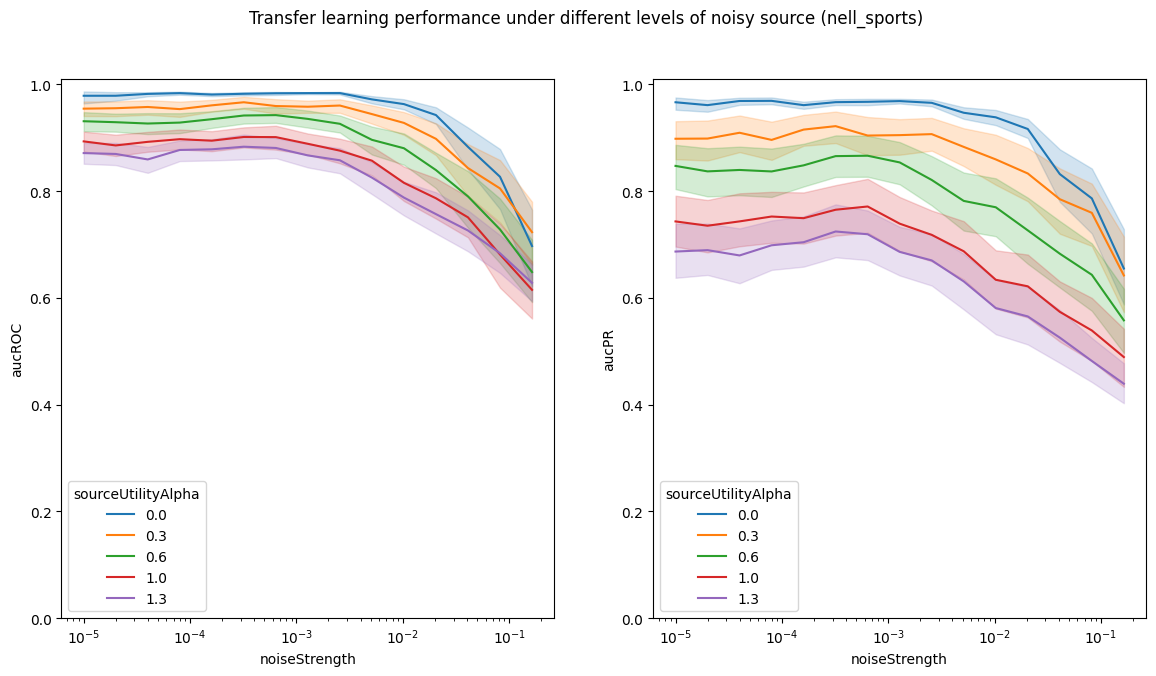

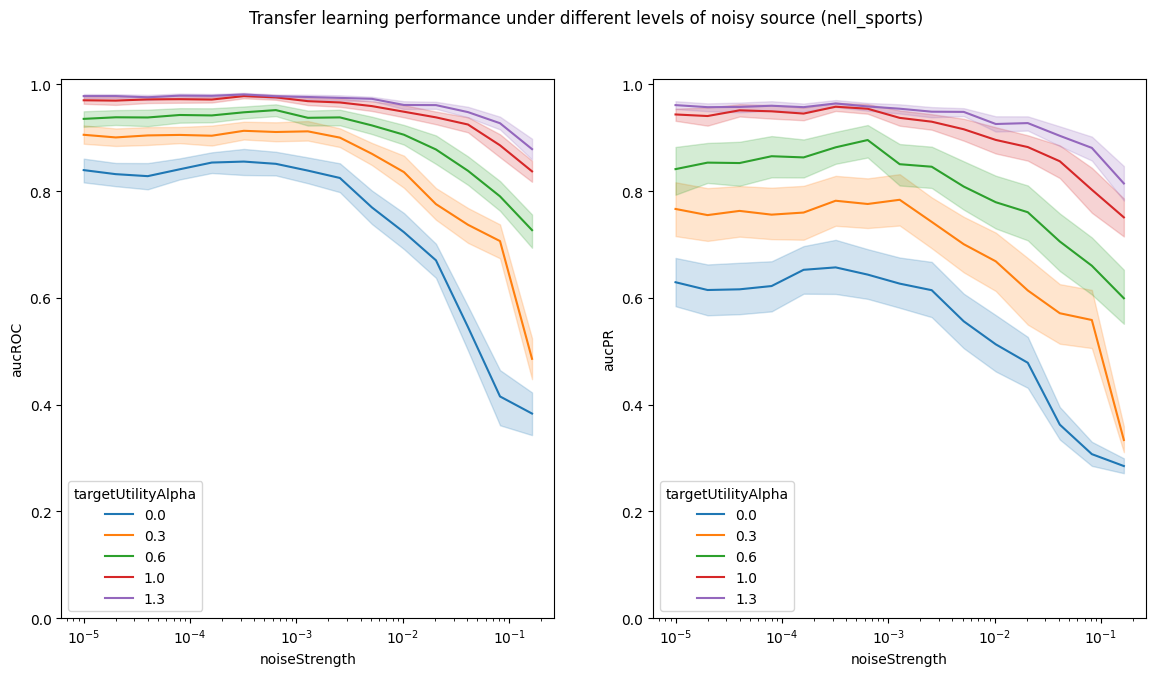

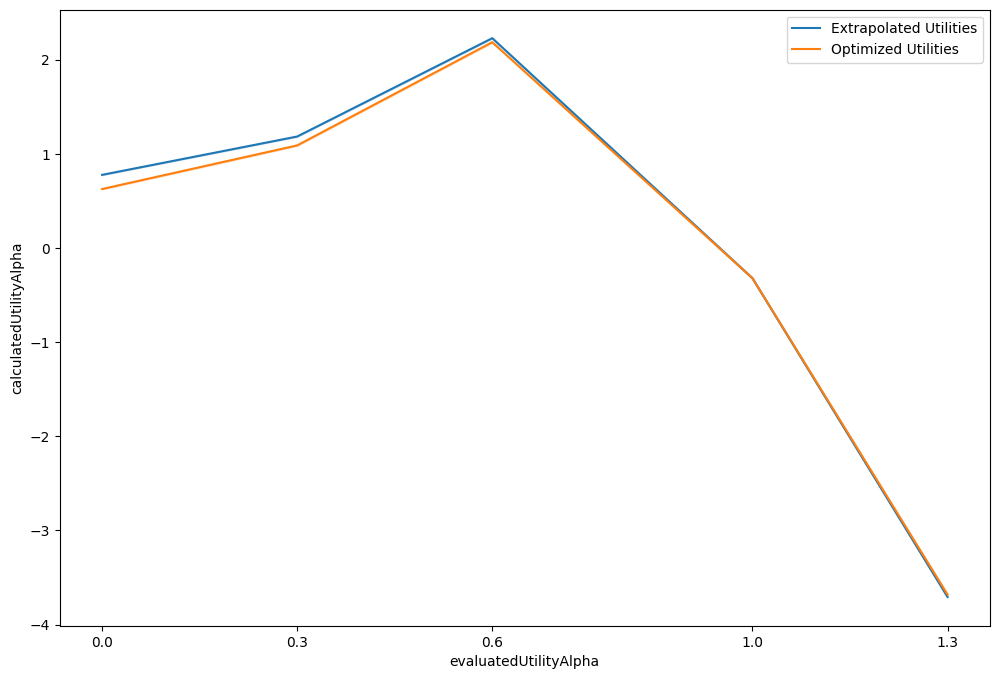

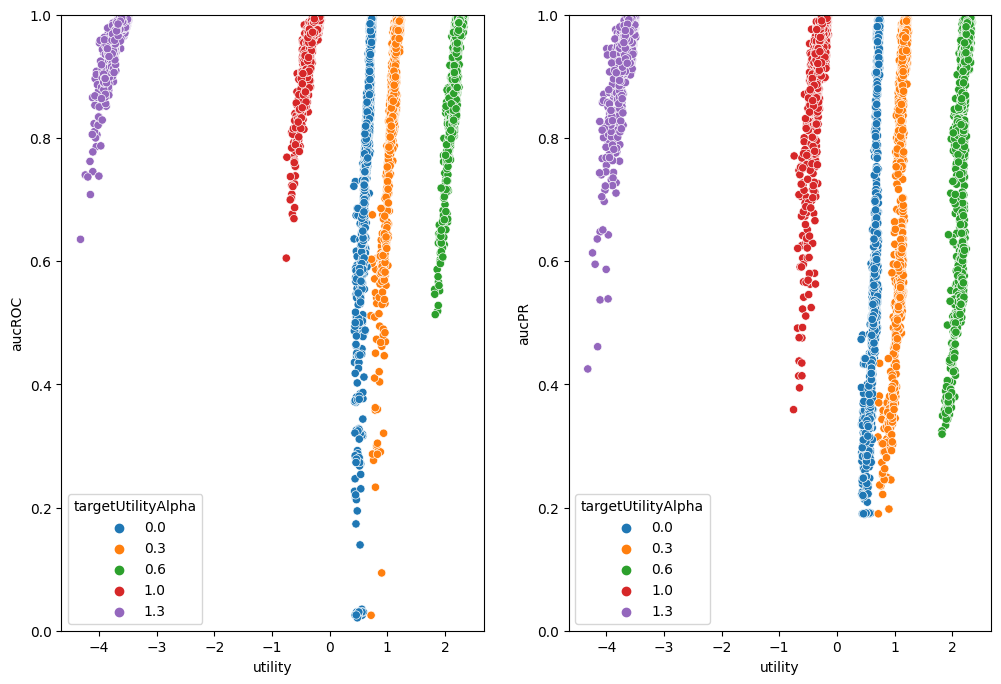

In [14]:
analysisVariables = runAnalysis("nell_sports")

Target Utility Alpha: 1.3


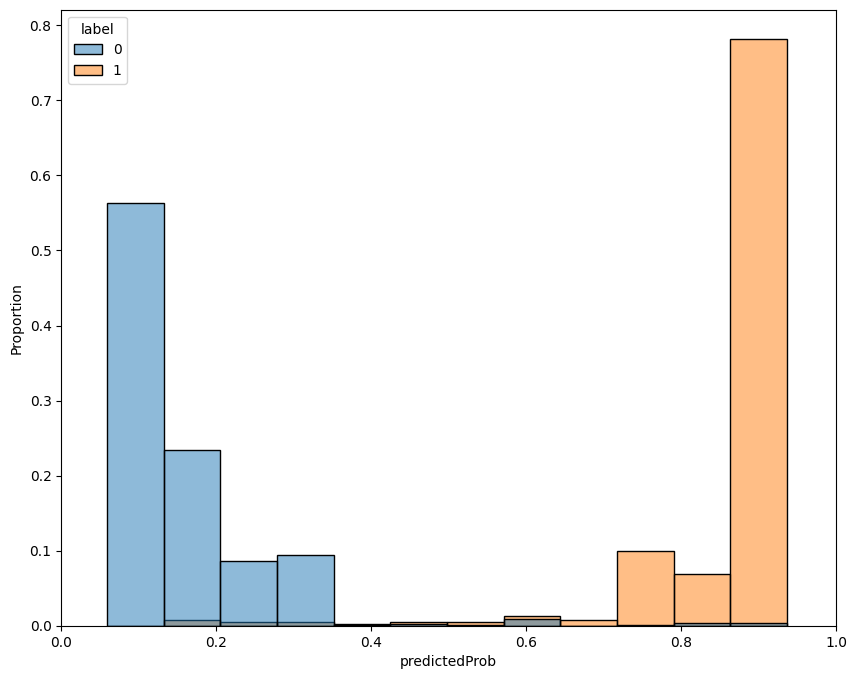

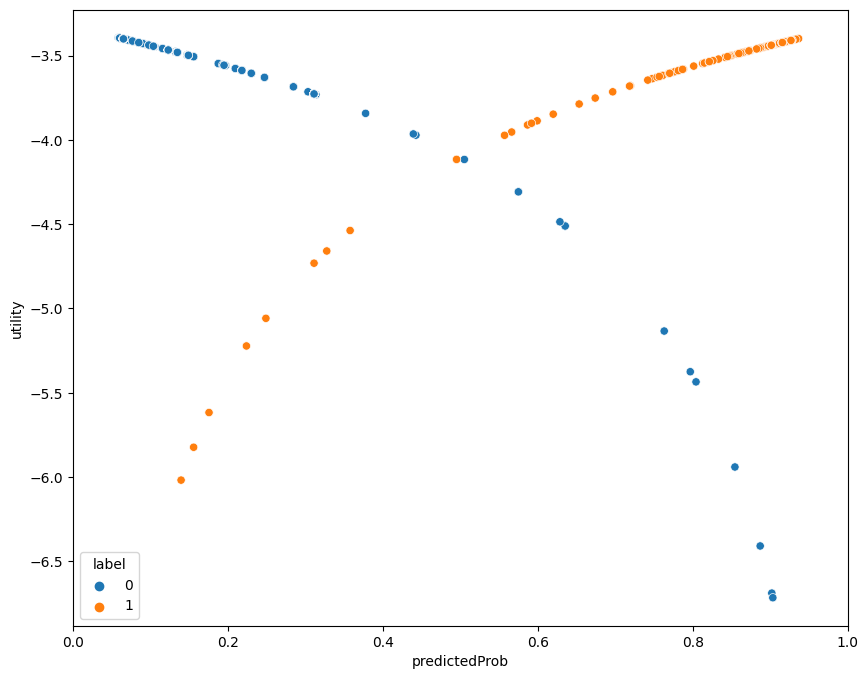

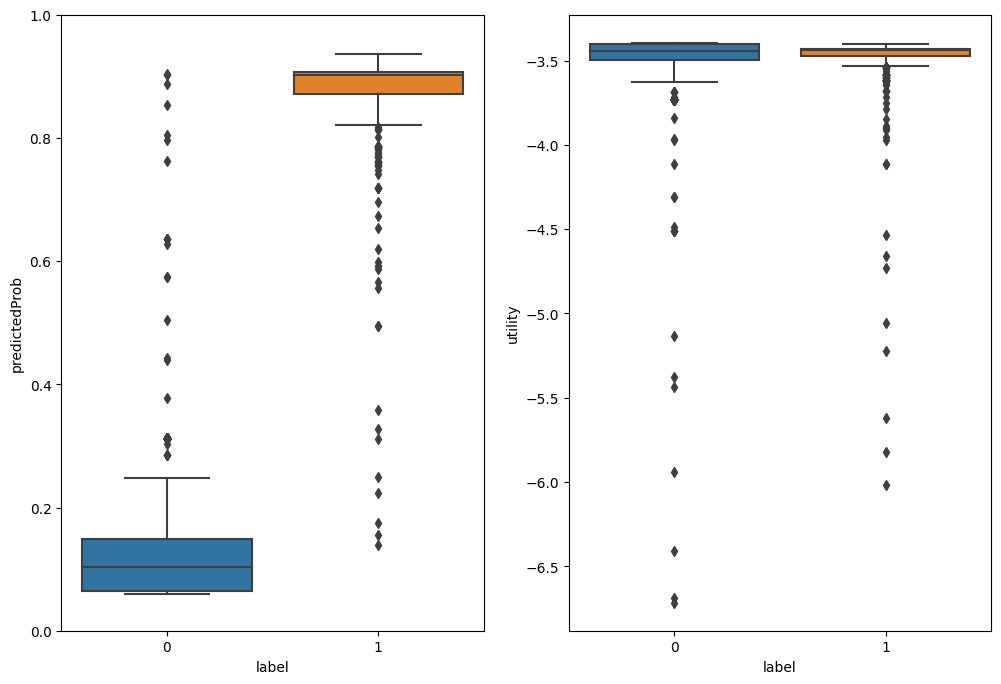

In [15]:
plotUtilityVsPredictedProb("6c20f5c8aa25b3bb71fbc2f0ce8cbd8b0072048bd20fcca51d76f04ec9e2cd42")

Target Utility Alpha: 0.0


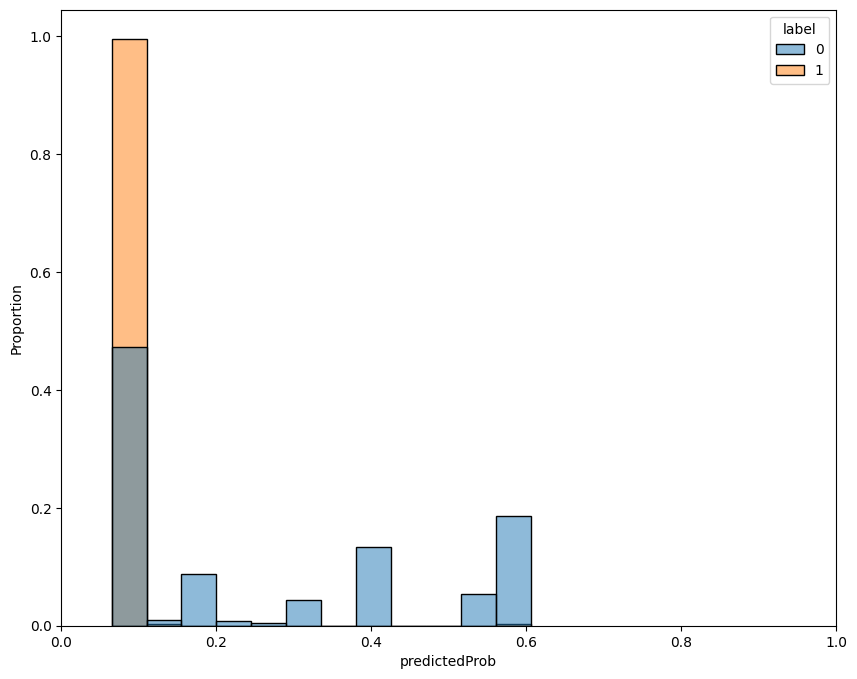

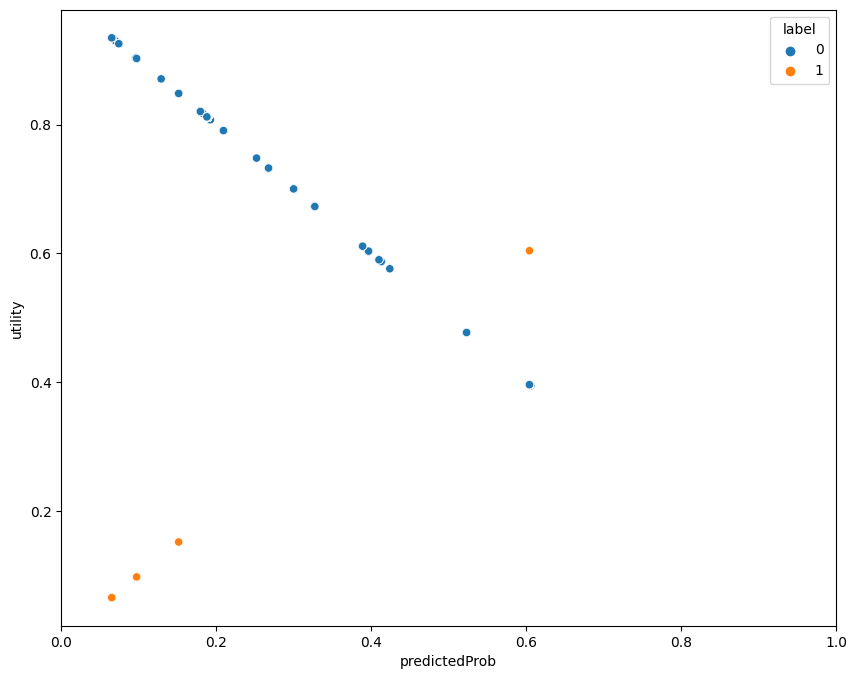

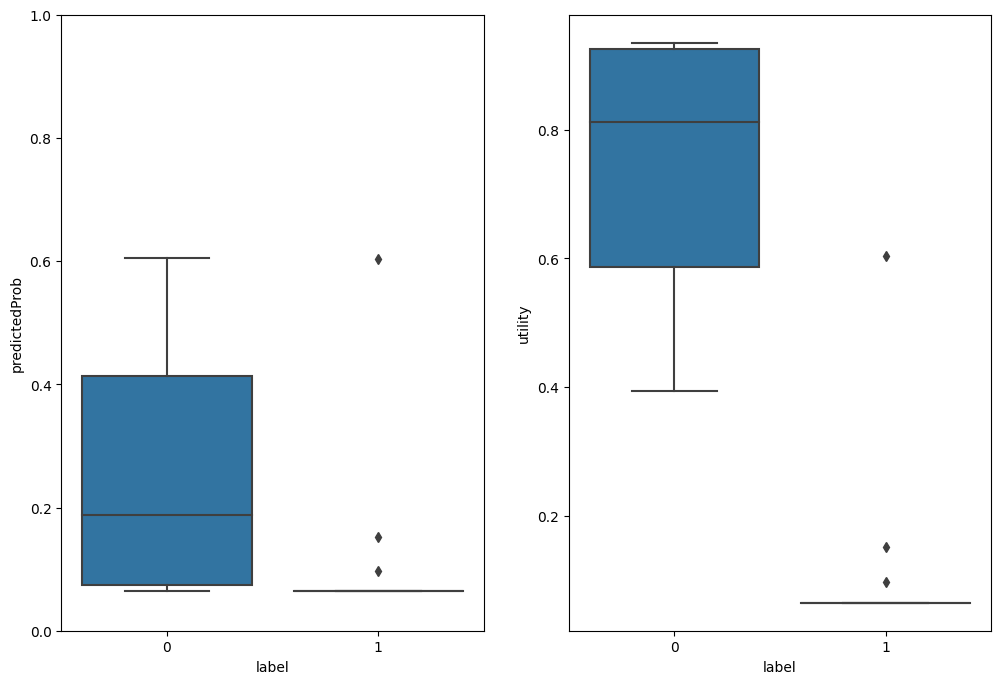

In [16]:
plotUtilityVsPredictedProb("c7dfd1b000f3bcc46fa27d0baea6edea5cf979eac7c2b002ea0518e05b50aeb9")

Pearson Correlation between AUC ROC and Utility at targetUtilityAlpha=0:
(0.7297003114927059, 5.238273685085619e-200)

Pearson Correlation between AUC PR and Utility at targetUtilityAlpha=0:
(0.7939034809899574, 4.1362716265614475e-261)


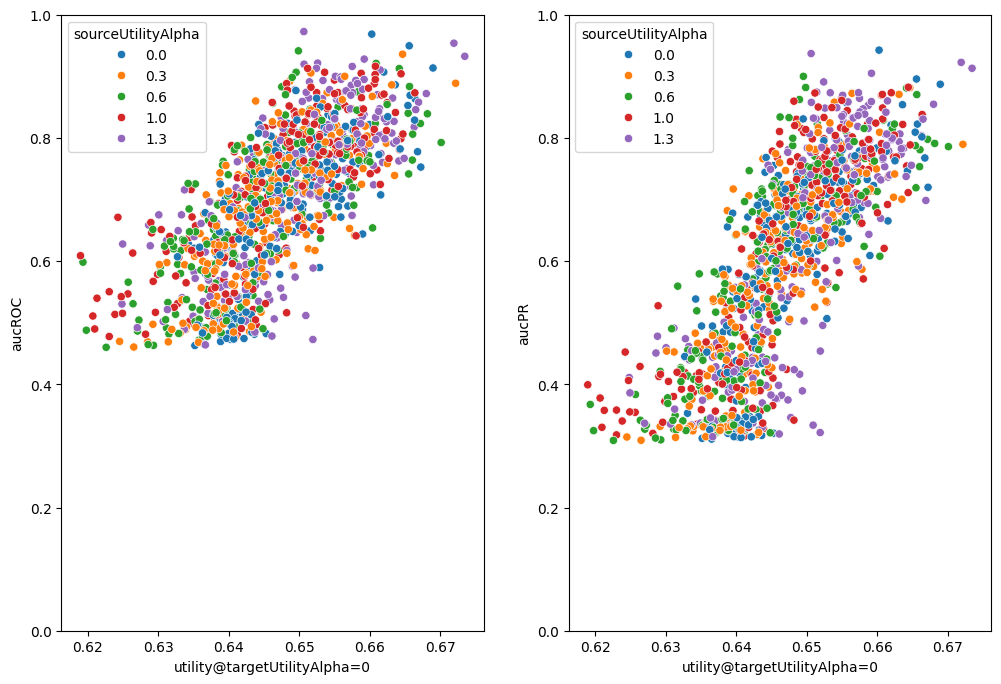

In [18]:
# Correlation between utility and AUC
database = "nell_sports"
targetUtilityAlpha = 0
aucUtilityPlotDF = pd.melt(
    utilityAlphaDF.drop(["experimentID"], axis = 1),
    id_vars = ["id", "database", "fold", "targetUtilityAlpha"],
    value_name = f"utility@targetUtilityAlpha={targetUtilityAlpha}",
    var_name = "evaluatedTargetUtilityAlpha"
)

aucUtilityPlotDF = aucUtilityPlotDF[
    (aucUtilityPlotDF.database == database) &
    (aucUtilityPlotDF.targetUtilityAlpha == targetUtilityAlpha)
]
aucUtilityPlotDF = pd.merge(
    aucUtilityPlotDF[
        (aucUtilityPlotDF.database == database)
    ],
    experimentsResultsDF[["id", "sourceUtilityAlpha"]],
    on = "id", 
    how = "left"
)

aucUtilityPlotDF["evaluatedTargetUtilityAlpha"] = aucUtilityPlotDF.evaluatedTargetUtilityAlpha.apply(
    lambda utilityAlpha: float(utilityAlpha.replace("utility@targetAlpha_", ""))
)
aucUtilityPlotDF = aucUtilityPlotDF[aucUtilityPlotDF.targetUtilityAlpha == aucUtilityPlotDF.evaluatedTargetUtilityAlpha]

aucUtilityPlotDF = pd.merge(
    metricsDF.rename(columns = {"experimentID": "id"}),
    aucUtilityPlotDF,
    on = ["id", "fold"],
    how = "inner"
)

aucUtilityPlotDF.head()

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12,8))

sns.scatterplot(
    data = aucUtilityPlotDF,
    x = f"utility@targetUtilityAlpha={targetUtilityAlpha}",
    y = "aucROC",
    hue = "sourceUtilityAlpha",
    palette = sns.color_palette(),
    ax = axs[0]
)
axs[0].set_ylim(0,1)

sns.scatterplot(
    data = aucUtilityPlotDF,
    x = f"utility@targetUtilityAlpha={targetUtilityAlpha}",
    y = "aucPR",
    hue = "sourceUtilityAlpha",
    palette = sns.color_palette(),
    ax = axs[1]
)
axs[1].set_ylim(0,1)

correlation_aucROC_utility = pearsonr(aucUtilityPlotDF[f"utility@targetUtilityAlpha={targetUtilityAlpha}"], aucUtilityPlotDF.aucROC)
print(f"Pearson Correlation between AUC ROC and Utility at targetUtilityAlpha={targetUtilityAlpha}:")
print(correlation_aucROC_utility)

print()

correlation_aucPR_utility = pearsonr(aucUtilityPlotDF[f"utility@targetUtilityAlpha={targetUtilityAlpha}"], aucUtilityPlotDF.aucPR)
print(f"Pearson Correlation between AUC PR and Utility at targetUtilityAlpha={targetUtilityAlpha}:")
print(correlation_aucPR_utility)